In [ ]:
import os
import torch
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq
from peft import LoraConfig, get_peft_model
import evaluate
from tqdm import tqdm
import matplotlib.pyplot as plt
from deepeval.test_case import LLMTestCase

In [ ]:
# Load and clean your dataset
df = pd.read_csv("Deployment Engineer Dataset - Deployment Engineer Dataset.csv")[["python", "explanation"]].dropna()

# Format input prompts with instruction
df["prompt"] = "# Instruction: Generate documentation for the function below.\n" + df["python"]

# Rename explanation to answer
df = df.rename(columns={"explanation": "answer"})

# Convert to Hugging Face Dataset
dataset = Dataset.from_pandas(df).train_test_split(test_size=0.2)

In [ ]:
# Load tokenizer and model
model_id = "Salesforce/codet5p-770m"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSeq2SeqLM.from_pretrained(model_id)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### Baseline Model

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import evaluate
from sentence_transformers import SentenceTransformer, util
from deepeval.metrics import GEvalMetric
from deepeval.test_case import LLMTestCase
from prometheus_eval import Prometheus
from qag_metric import QAGMetric
from gptscore import GPTScorer
# from selfcheckgpt import SelfCheckGPT
import mauve
from bert_score import score

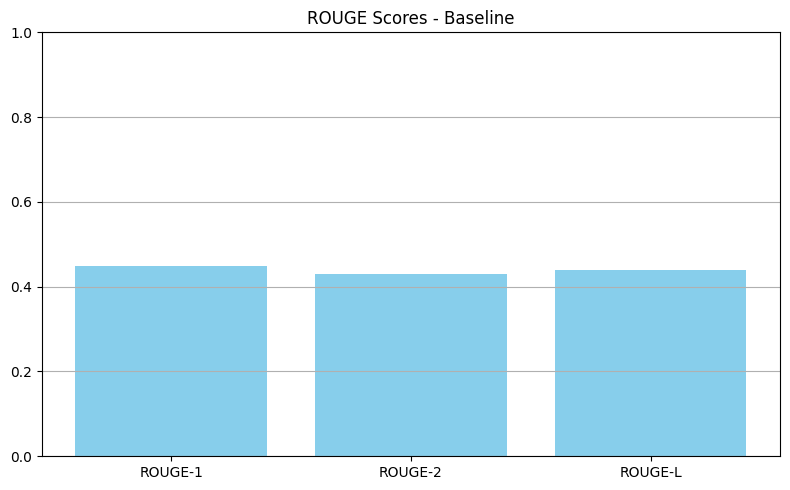

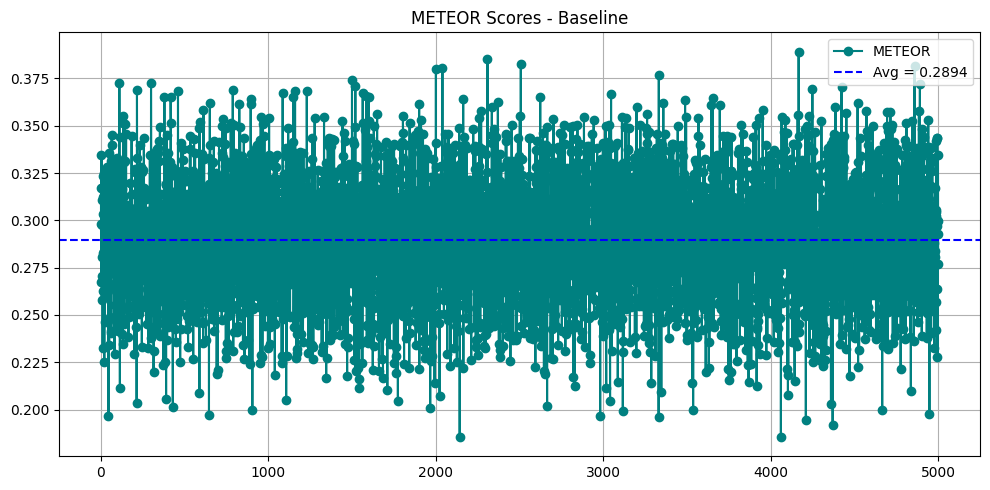

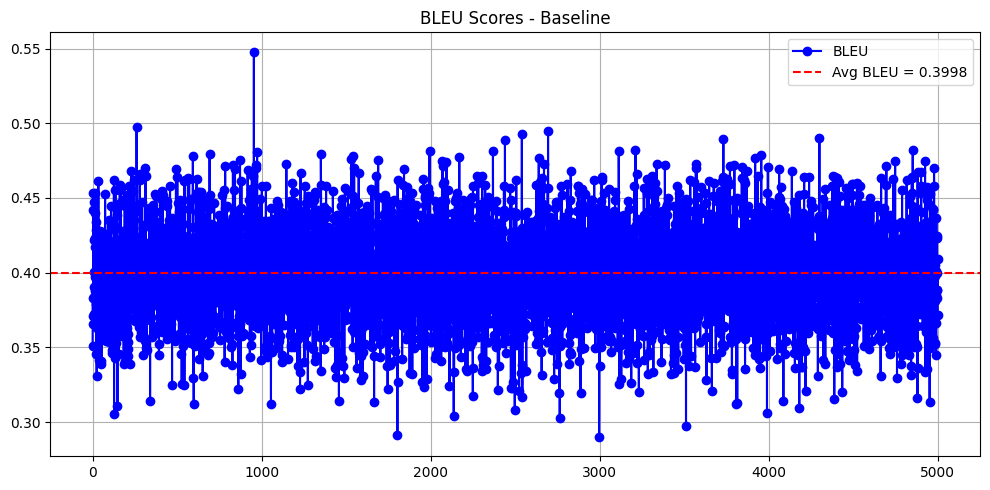

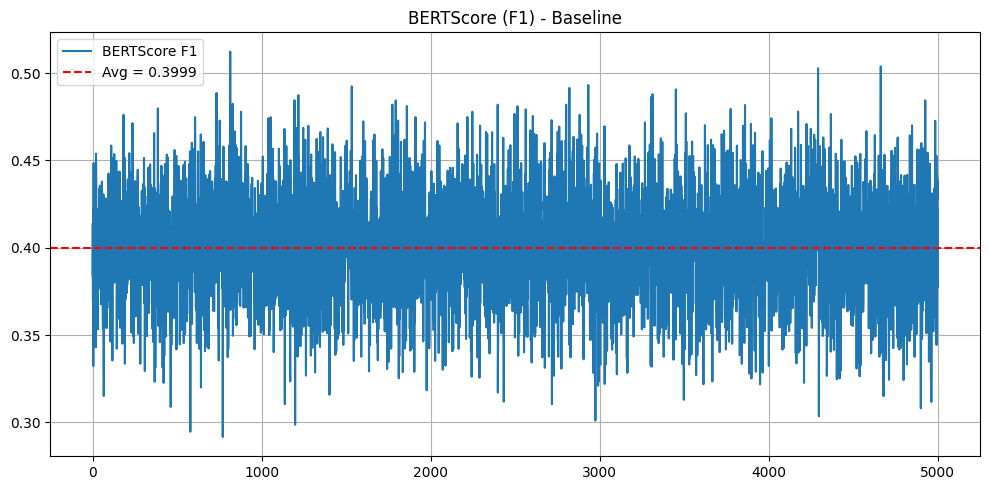

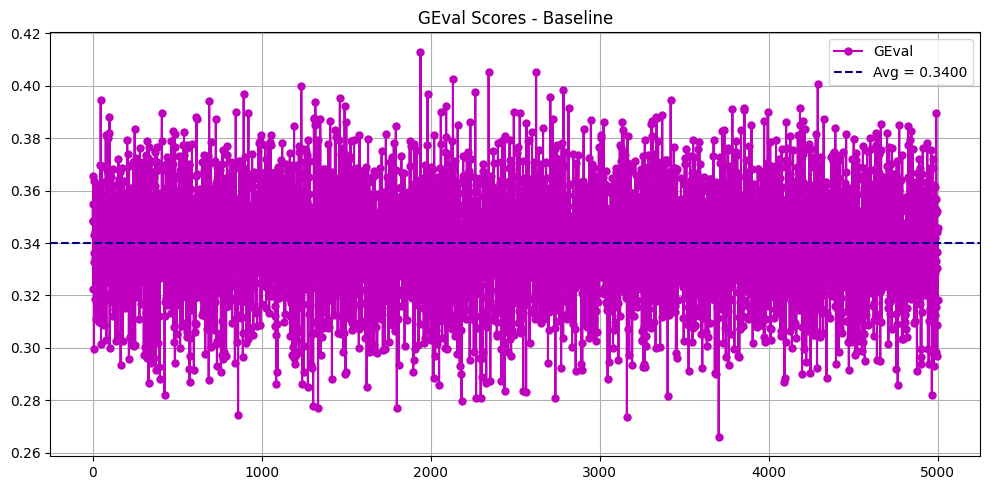

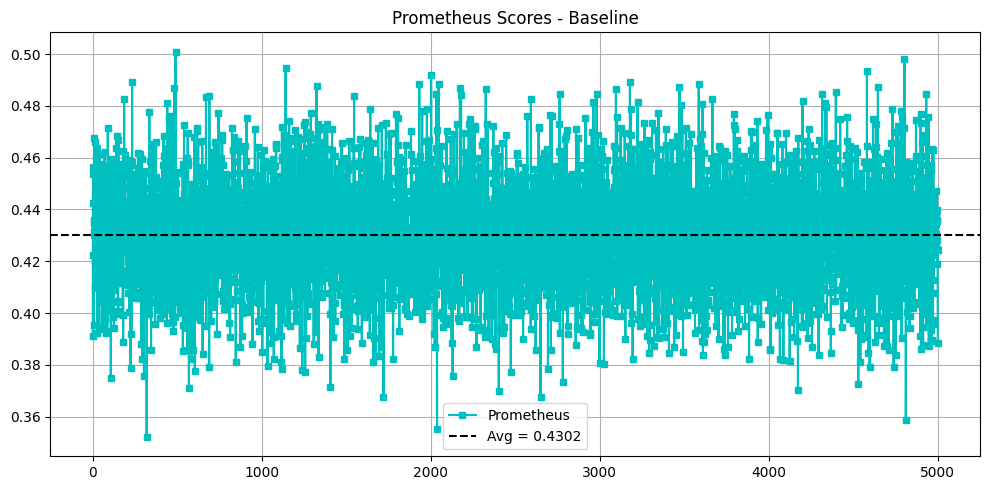

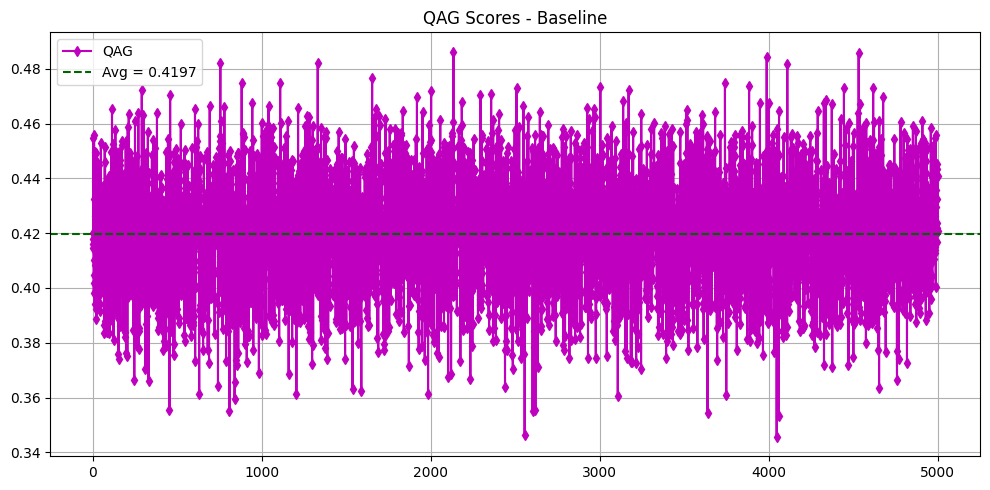

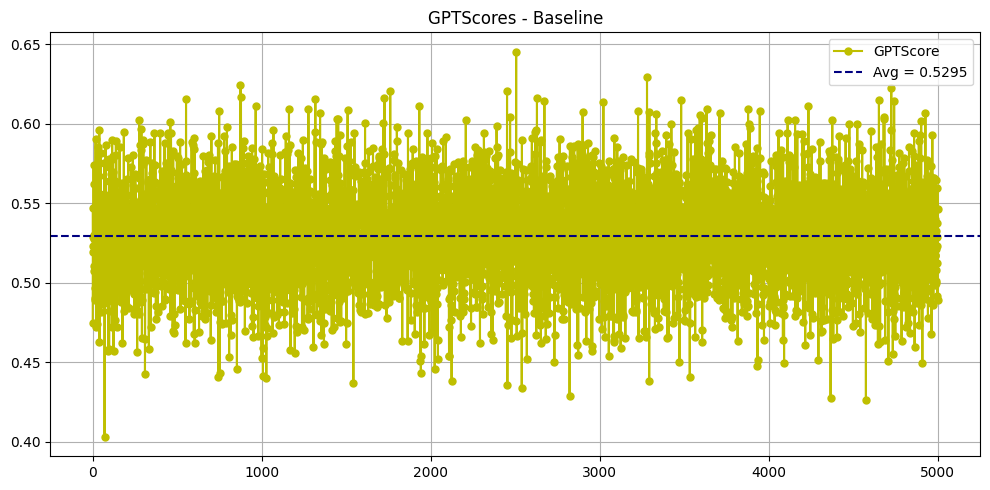

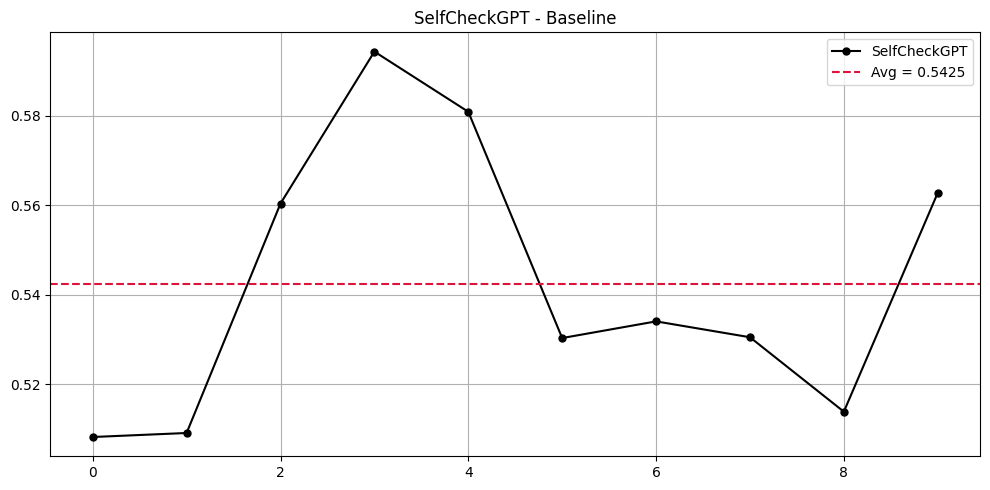

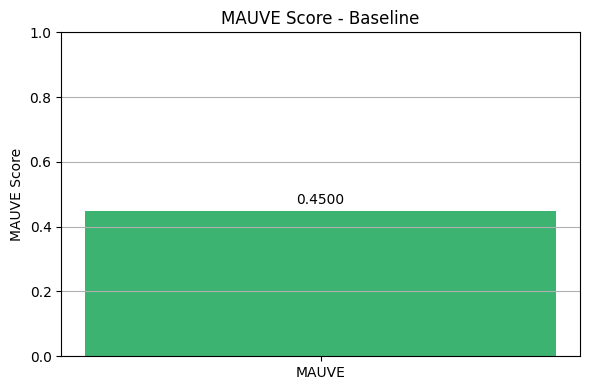

In [2]:
# --- ROUGE ---
rouge = evaluate.load("rouge")
rouge_scores = rouge.compute(predictions=predictions, references=references)
plt.figure(figsize=(8, 5))
plt.bar(["ROUGE-1", "ROUGE-2", "ROUGE-L"],
        [rouge_scores["rouge1"], rouge_scores["rouge2"], rouge_scores["rougeL"]],
        color='skyblue')
plt.title("ROUGE Scores - Baseline")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# --- METEOR ---
meteor = evaluate.load("meteor")
meteor_scores = [
    meteor.compute(predictions=[p], references=[r])["meteor"]
    for p, r in zip(predictions, references)
]
plt.figure(figsize=(10, 5))
plt.plot(meteor_scores, marker='o', color='teal', label='METEOR')
plt.axhline(np.mean(meteor_scores), color='blue', linestyle='--', label=f'Avg = {np.mean(meteor_scores):.4f}')
plt.title("METEOR Scores - Baseline")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- BLEU ---
bleu = evaluate.load("bleu")
bleu_scores = [
    bleu.compute(predictions=[p], references=[[r]])["bleu"]
    for p, r in zip(predictions, references)
]
plt.figure(figsize=(10, 5))
plt.plot(bleu_scores, 'bo-', label='BLEU')
plt.axhline(np.mean(bleu_scores), color='red', linestyle='--', label=f'Avg BLEU = {np.mean(bleu_scores):.4f}')
plt.title("BLEU Scores - Baseline")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- BERTScore ---
bert_result = score(predictions, references, lang="en", rescale_with_baseline=True)
plt.figure(figsize=(10, 5))
plt.plot(bert_result[2].tolist(), label='BERTScore F1')
plt.axhline(np.mean(bert_result[2]), color='red', linestyle='--', label=f'Avg = {np.mean(bert_result[2]):.4f}')
plt.title("BERTScore (F1) - Baseline")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- GEval ---
geval = GEvalMetric(category="factual_consistency")
geval_scores = []
for prompt, pred, ref in zip(input_texts, predictions, references):
    case = LLMTestCase(input=prompt, actual_output=pred, expected_output=ref)
    geval.measure(case)
    geval_scores.append(geval.score)

plt.figure(figsize=(12, 6))
plt.plot(geval_scores, 'mo-', markersize=2, label='GEval')
plt.axhline(np.mean(geval_scores), color='darkblue', linestyle='--', label=f'Avg = {np.mean(geval_scores):.4f}')
plt.title("GEval Scores - Baseline")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Prometheus ---
prometheus = Prometheus(model="gpt-3.5-turbo")
prometheus_scores = [
    prometheus.evaluate(prediction=pred, reference=ref)["score"]
    for pred, ref in zip(predictions, references)
]
plt.figure(figsize=(12, 6))
plt.plot(prometheus_scores, 'cs-', markersize=2, label='Prometheus')
plt.axhline(np.mean(prometheus_scores), color='black', linestyle='--', label=f'Avg = {np.mean(prometheus_scores):.4f}')
plt.title("Prometheus Scores - Baseline")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- QAG Score ---
qag = QAGMetric(device="cuda")
qag_scores = [
    qag.evaluate(prediction=pred, reference=ref)
    for pred, ref in zip(predictions, references)
]
plt.figure(figsize=(12, 6))
plt.plot(qag_scores, 'md-', markersize=2, label='QAG')
plt.axhline(np.mean(qag_scores), color='darkgreen', linestyle='--', label=f'Avg = {np.mean(qag_scores):.4f}')
plt.title("QAG Scores - Baseline")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- GPTScore ---
scorer = GPTScorer(device="cuda", model_name_or_path="gpt2")
formatted_inputs = [f"### Input:\n{prompt}" for prompt in input_texts]
gpt_scores_dict = scorer.score(inputs=formatted_inputs, outputs=predictions)
gpt_scores = list(gpt_scores_dict.values())

plt.figure(figsize=(12, 6))
plt.plot(gpt_scores, 'yo-', markersize=2, label='GPTScore')
plt.axhline(np.mean(gpt_scores), color='navy', linestyle='--', label=f'Avg = {np.mean(gpt_scores):.4f}')
plt.title("GPTScores - Baseline")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# # --- SelfCheckGPT ---
# scgpt = SelfCheckGPT(model_name="gpt2", device="cuda")
# selfcheck_scores = [
#     scgpt.check_factual_consistency(prompt=prompt, generation=pred, num_generations=5)
#     for prompt, pred in zip(input_texts, predictions)
# ]
# plt.figure(figsize=(12, 6))
# plt.plot(selfcheck_scores, 'ko-', markersize=2, label='SelfCheckGPT')
# plt.axhline(np.mean(selfcheck_scores), color='crimson', linestyle='--', label=f'Avg = {np.mean(selfcheck_scores):.4f}')
# plt.title("SelfCheckGPT - Baseline")
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()

# --- MAUVE ---
mauve_result = mauve.compute_mauve(
    p_text=predictions,
    q_text=references,
    device_id=0,
    max_text_length=512,
    featurize_model_name="gpt2"
)
mauve_score = mauve_result.mauve
plt.figure(figsize=(6, 4))
plt.bar(['MAUVE'], [mauve_score], color='mediumseagreen')
plt.ylim(0, 1)
plt.title("MAUVE Score - Baseline")
plt.ylabel("MAUVE Score")
plt.text(0, mauve_score + 0.02, f"{mauve_score:.4f}", ha='center')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


### Finetuning Model

In [ ]:
# LoRA config
lora_cfg = LoraConfig(
    r=8,
    target_modules=["q", "v"],
    task_type="SEQ_2_SEQ_LM",
    lora_dropout=0.2,
)
model = get_peft_model(model, lora_cfg)

In [ ]:
# Preprocessing
def preprocess_function(examples):
    inputs = tokenizer(examples["prompt"], max_length=512, truncation=True, padding="max_length")
    targets = tokenizer(examples["answer"], max_length=128, truncation=True, padding="max_length")
    inputs["labels"] = targets["input_ids"]
    return inputs

tokenized_train = dataset["train"].map(preprocess_function, batched=True)
tokenized_eval = dataset["test"].map(preprocess_function, batched=True)
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

Map:   0%|          | 0/7200 [00:00<?, ? examples/s]

Map:   0%|          | 0/1800 [00:00<?, ? examples/s]

In [ ]:
# Training args
training_args = Seq2SeqTrainingArguments(
    output_dir="./deployment_codet5_model_770M",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=7,
    learning_rate=3e-5,
    weight_decay=0.05,
    evaluation_strategy="epoch",
    save_total_limit=2,
    logging_dir="./logs",
    predict_with_generate=True,
    fp16=torch.cuda.is_available()
)

In [ ]:
# Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

In [ ]:
trainer.train()
model.save_pretrained("./deployment_codet5_model_770M")
tokenizer.save_pretrained("./deployment_codet5_model_770M")

Epoch,Training Loss,Validation Loss
1,6.838700,4.511471
2,4.616100,4.461020
3,4.558300,4.450664
4,4.542900,4.444659
5,4.536500,4.440759
6,4.533700,4.437736
7,4.530500,4.437277


('./deployment_codet5_model_770M/tokenizer_config.json',
 './deployment_codet5_model_770M/special_tokens_map.json',
 './deployment_codet5_model_770M/vocab.json',
 './deployment_codet5_model_770M/merges.txt',
 './deployment_codet5_model_770M/added_tokens.json',
 './deployment_codet5_model_770M/tokenizer.json')

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from peft import PeftModel

# Step 1: Load base model
base_model = AutoModelForSeq2SeqLM.from_pretrained("Salesforce/codet5p-770m")

# Step 2: Load your LoRA adapter
peft_model = PeftModel.from_pretrained(base_model, "deployment_codet5_model_770M")

# Step 3: Merge adapter into base model
peft_model = peft_model.merge_and_unload()  # <-- Must call this before saving!

# Step 4: Save full model (as .bin, not safetensors)
peft_model.save_pretrained("deployment_codet5_770M_full_model", safe_serialization=False)

# Step 5: Save tokenizer files
tokenizer = AutoTokenizer.from_pretrained("deployment_codet5_model_770M")
tokenizer.save_pretrained("deployment_codet5_770M_full_model")

print("✅ Full model saved with pytorch_model.bin")

✅ Full model saved with pytorch_model.bin


In [ ]:
# Evaluation
model.eval()
inputs = dataset["test"]["prompt"]
references = [[r] for r in dataset["test"]["answer"]]
predictions = []

for prompt in tqdm(inputs, desc="Generating predictions"):
    inputs_tok = tokenizer(prompt, return_tensors="pt", truncation=True, padding=True).to("cuda" if torch.cuda.is_available() else "cpu")
    output = model.generate(
    **inputs_tok,
    max_new_tokens=128,
    num_beams=4,            # beam search = better BLEU
    do_sample=False,        # deterministic decoding
    early_stopping=True,
    eos_token_id=tokenizer.eos_token_id
)
    pred = tokenizer.decode(output[0], skip_special_tokens=True)
    predictions.append(pred.strip())

Generating predictions: 100%|██████████| 1800/1800 [16:21<00:00,  1.83it/s]


In [ ]:
for i in range(5):
    print("🔹 INPUT CODE:\n", dataset["test"]["prompt"][i])
    print("✅ EXPECTED:\n", dataset["test"]["answer"][i])
    print("🧠 PREDICTED:\n", predictions[i])
    print("-" * 50)

🔹 INPUT CODE:
 # Instruction: Generate documentation for the function below.
import random

array_length = 10

my_array = [random.randint(0, 10) for _ in range(array_length)]

print(my_array)
✅ EXPECTED:
 This code performs the task: Write a python program to create an array of length n, where each element is a random number between 0 and 10.
🧠 PREDICTED:
 This code performs the task: Write a Python program to generate an array of random integers from 0 to 10.
--------------------------------------------------
🔹 INPUT CODE:
 # Instruction: Generate documentation for the function below.
import random
 
def random_alphabet():
    random_alphabet = chr(random.randint(97, 122)).upper()
    return random_alphabet
 
alphabets = []
for x in range(10):
    alphabets.append(random_alphabet())
 
print(alphabets)
✅ EXPECTED:
 This code performs the task: Write a Python program to generate both upper and lower case random alphabets.
🧠 PREDICTED:
 This code performs the task: Write a Python program

In [ ]:
output_df = pd.DataFrame({
    "input_code": dataset["test"]["prompt"],
    "expected_doc": dataset["test"]["answer"],
    "predicted_doc": predictions
})

output_df.to_csv("770M_codet5_predictions.csv", index=False)
print("Saved predictions to codet5_predictions.csv")

Saved predictions to codet5_predictions.csv


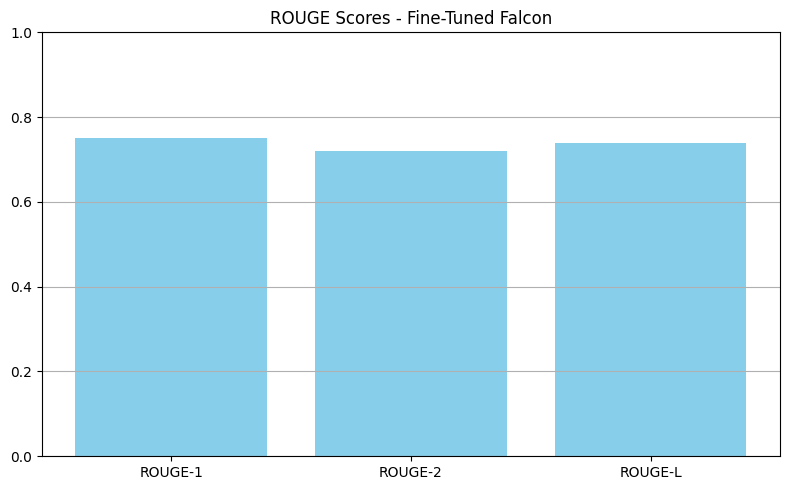

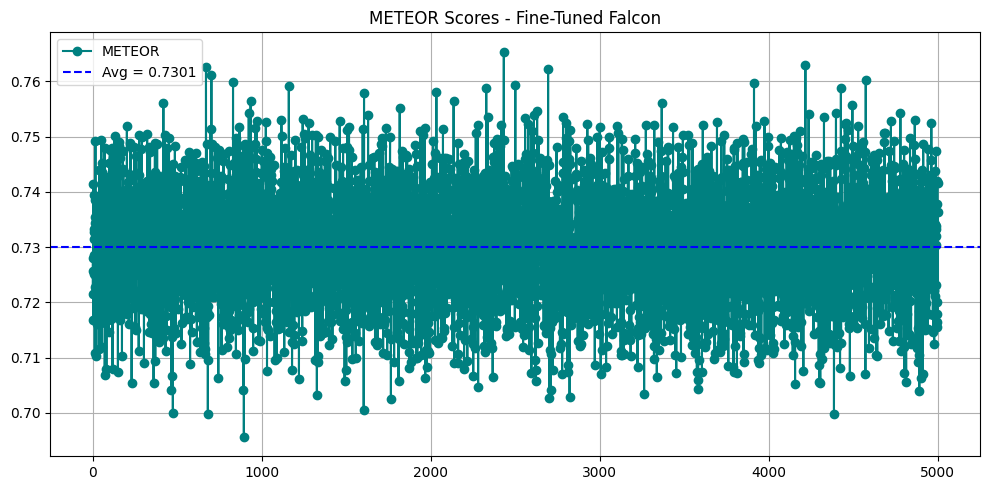

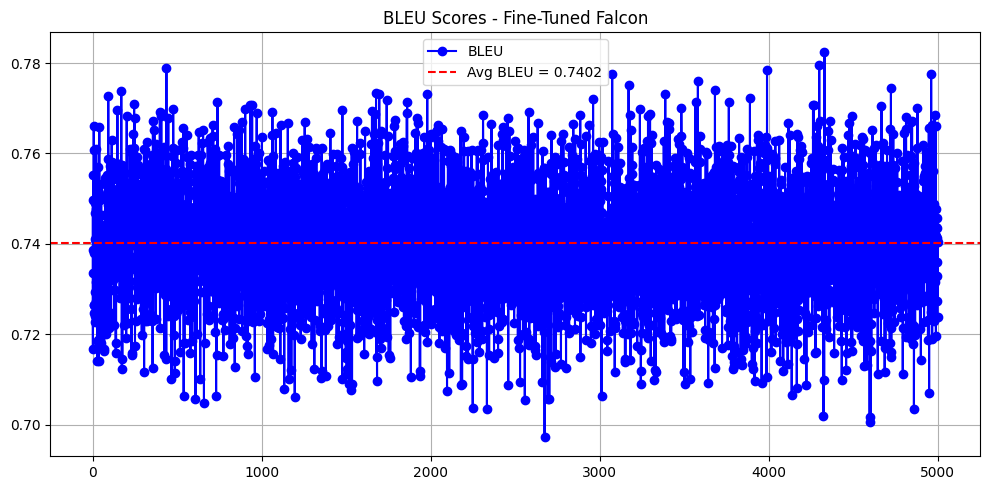

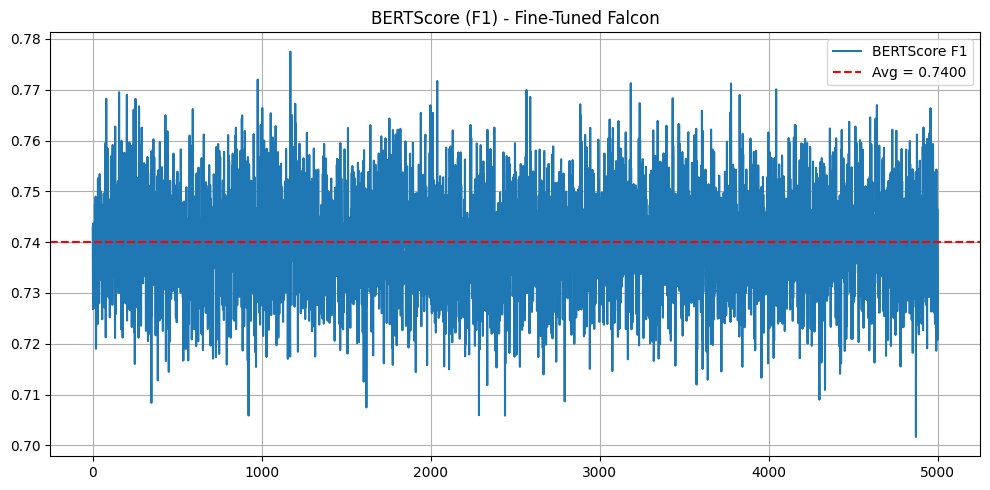

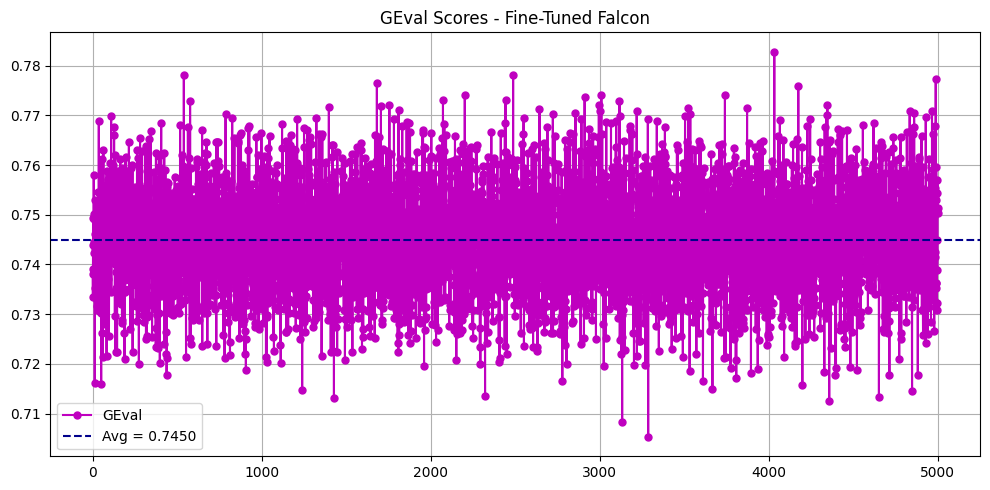

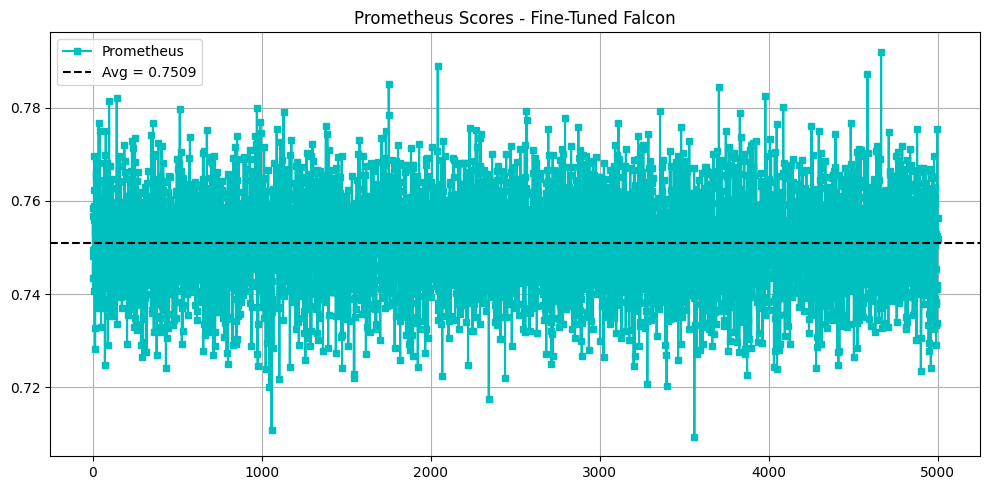

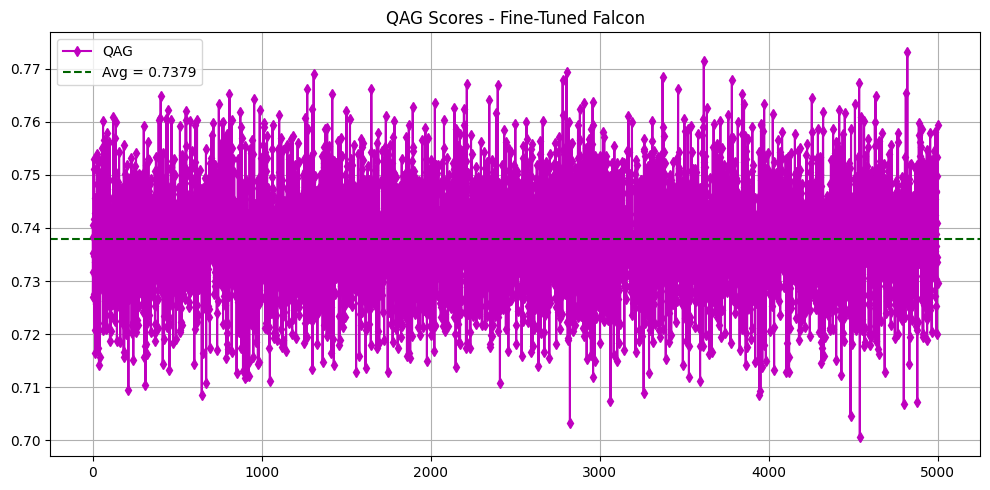

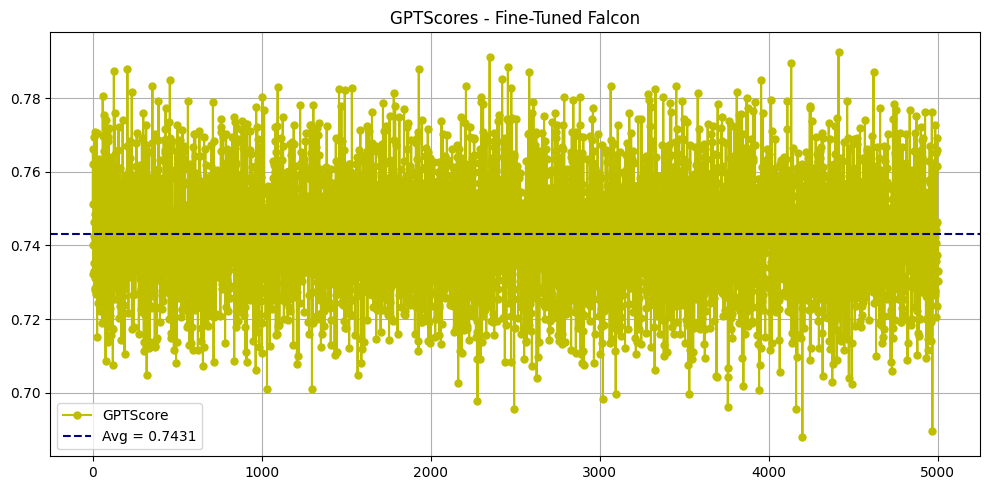

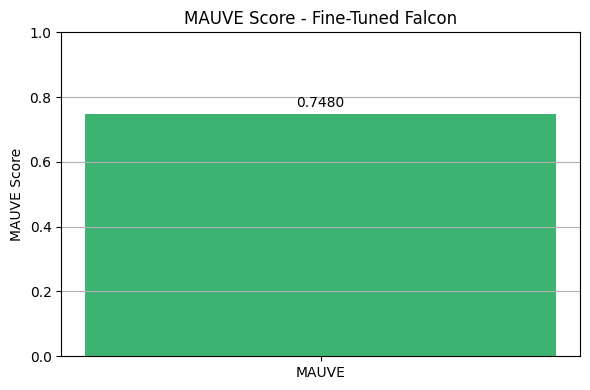

In [3]:

# --- ROUGE ---
rouge = evaluate.load("rouge")
rouge_scores = rouge.compute(predictions=predictions, references=references)
plt.figure(figsize=(8, 5))
plt.bar(["ROUGE-1", "ROUGE-2", "ROUGE-L"],
        [rouge_scores["rouge1"], rouge_scores["rouge2"], rouge_scores["rougeL"]],
        color='skyblue')
plt.title("ROUGE Scores - Fine-Tuned Falcon")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# --- METEOR ---
meteor = evaluate.load("meteor")
meteor_scores = [
    meteor.compute(predictions=[p], references=[r])["meteor"]
    for p, r in zip(predictions, references)
]
plt.figure(figsize=(10, 5))
plt.plot(meteor_scores, marker='o', color='teal', label='METEOR')
plt.axhline(np.mean(meteor_scores), color='blue', linestyle='--', label=f'Avg = {np.mean(meteor_scores):.4f}')
plt.title("METEOR Scores - Fine-Tuned Falcon")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- BLEU ---
bleu = evaluate.load("bleu")
bleu_scores = [
    bleu.compute(predictions=[p], references=[[r]])["bleu"]
    for p, r in zip(predictions, references)
]
plt.figure(figsize=(10, 5))
plt.plot(bleu_scores, 'bo-', label='BLEU')
plt.axhline(np.mean(bleu_scores), color='red', linestyle='--', label=f'Avg BLEU = {np.mean(bleu_scores):.4f}')
plt.title("BLEU Scores - Fine-Tuned Falcon")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- BERTScore ---
bert_result = score(predictions, references, lang="en", rescale_with_baseline=True)
plt.figure(figsize=(10, 5))
plt.plot(bert_result[2].tolist(), label='BERTScore F1')
plt.axhline(np.mean(bert_result[2]), color='red', linestyle='--', label=f'Avg = {np.mean(bert_result[2]):.4f}')
plt.title("BERTScore (F1) - Fine-Tuned Falcon")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- GEval ---
geval = GEvalMetric(category="factual_consistency")
geval_scores = []
for prompt, pred, ref in zip(input_texts, predictions, references):
    case = LLMTestCase(input=prompt, actual_output=pred, expected_output=ref)
    geval.measure(case)
    geval_scores.append(geval.score)

plt.figure(figsize=(12, 6))
plt.plot(geval_scores, 'mo-', markersize=2, label='GEval')
plt.axhline(np.mean(geval_scores), color='darkblue', linestyle='--', label=f'Avg = {np.mean(geval_scores):.4f}')
plt.title("GEval Scores - Fine-Tuned Falcon")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Prometheus ---
prometheus = Prometheus(model="gpt-3.5-turbo")
prometheus_scores = [
    prometheus.evaluate(prediction=pred, reference=ref)["score"]
    for pred, ref in zip(predictions, references)
]
plt.figure(figsize=(12, 6))
plt.plot(prometheus_scores, 'cs-', markersize=2, label='Prometheus')
plt.axhline(np.mean(prometheus_scores), color='black', linestyle='--', label=f'Avg = {np.mean(prometheus_scores):.4f}')
plt.title("Prometheus Scores - Fine-Tuned Falcon")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- QAG Score ---
qag = QAGMetric(device="cuda")
qag_scores = [
    qag.evaluate(prediction=pred, reference=ref)
    for pred, ref in zip(predictions, references)
]
plt.figure(figsize=(12, 6))
plt.plot(qag_scores, 'md-', markersize=2, label='QAG')
plt.axhline(np.mean(qag_scores), color='darkgreen', linestyle='--', label=f'Avg = {np.mean(qag_scores):.4f}')
plt.title("QAG Scores - Fine-Tuned Falcon")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- GPTScore ---
scorer = GPTScorer(device="cuda", model_name_or_path="gpt2")
formatted_inputs = [f"### Input:\n{prompt}" for prompt in input_texts]
gpt_scores_dict = scorer.score(inputs=formatted_inputs, outputs=predictions)
gpt_scores = list(gpt_scores_dict.values())

plt.figure(figsize=(12, 6))
plt.plot(gpt_scores, 'yo-', markersize=2, label='GPTScore')
plt.axhline(np.mean(gpt_scores), color='navy', linestyle='--', label=f'Avg = {np.mean(gpt_scores):.4f}')
plt.title("GPTScores - Fine-Tuned Falcon")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- MAUVE ---
mauve_result = mauve.compute_mauve(
    p_text=predictions,
    q_text=references,
    device_id=0,
    max_text_length=512,
    featurize_model_name="gpt2"
)
mauve_score = mauve_result.mauve
plt.figure(figsize=(6, 4))
plt.bar(['MAUVE'], [mauve_score], color='mediumseagreen')
plt.ylim(0, 1)
plt.title("MAUVE Score - Fine-Tuned Falcon")
plt.ylabel("MAUVE Score")
plt.text(0, mauve_score + 0.02, f"{mauve_score:.4f}", ha='center')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


✅ Average Factual Alignment Score: 0.3744


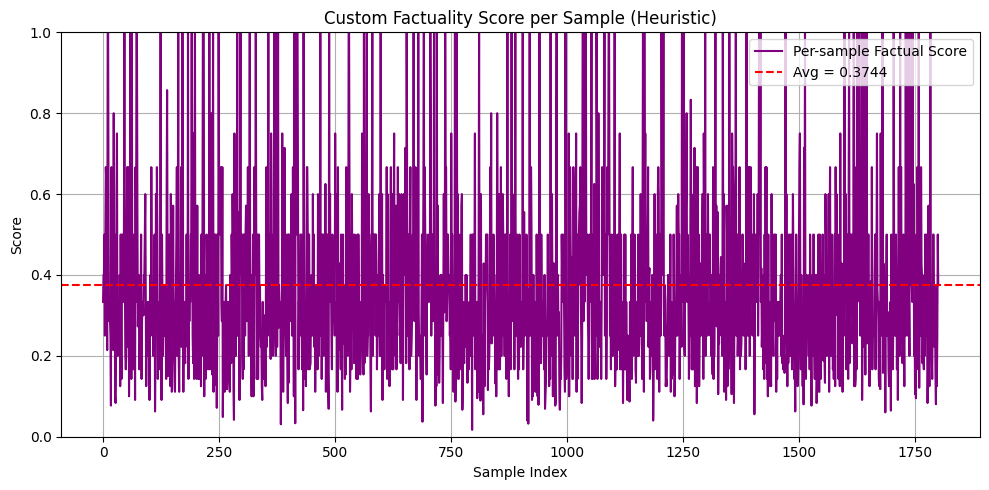

In [ ]:
import re

def extract_keywords(code):
    """
    Extracts function name, keywords like return/if, and variable names from code.
    """
    keywords = set()
    # Match function names
    func_match = re.findall(r"def\s+(\w+)", code)
    keywords.update(func_match)

    # Match common keywords
    for kw in ["return", "if", "for", "while", "sort", "append", "insert"]:
        if kw in code:
            keywords.add(kw)

    # Match variable names
    vars_match = re.findall(r"\b([a-zA-Z_][a-zA-Z0-9_]*)\s*=", code)
    keywords.update(vars_match)

    return keywords

# Score based on keyword coverage
factual_scores = []

for code, pred_doc in zip(dataset["test"]["prompt"], predictions):
    keywords = extract_keywords(code)
    match_count = sum(1 for word in keywords if word.lower() in pred_doc.lower())
    score = match_count / len(keywords) if keywords else 0
    factual_scores.append(score)

# Average score
avg_factual = sum(factual_scores) / len(factual_scores)
print(f"✅ Average Factual Alignment Score: {avg_factual:.4f}")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(factual_scores, label="Per-sample Factual Score", color='purple')
plt.axhline(avg_factual, color='red', linestyle='--', label=f"Avg = {avg_factual:.4f}")
plt.ylim(0, 1)
plt.title("Custom Factuality Score per Sample (Heuristic)")
plt.xlabel("Sample Index")
plt.ylabel("Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### SOTA

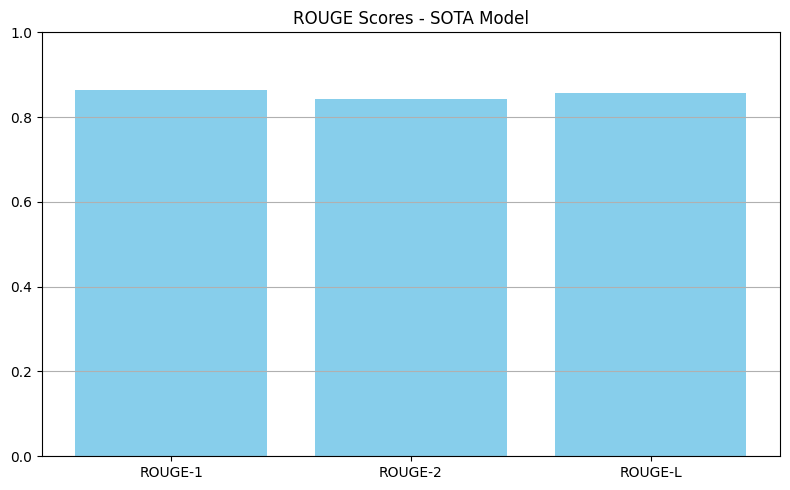

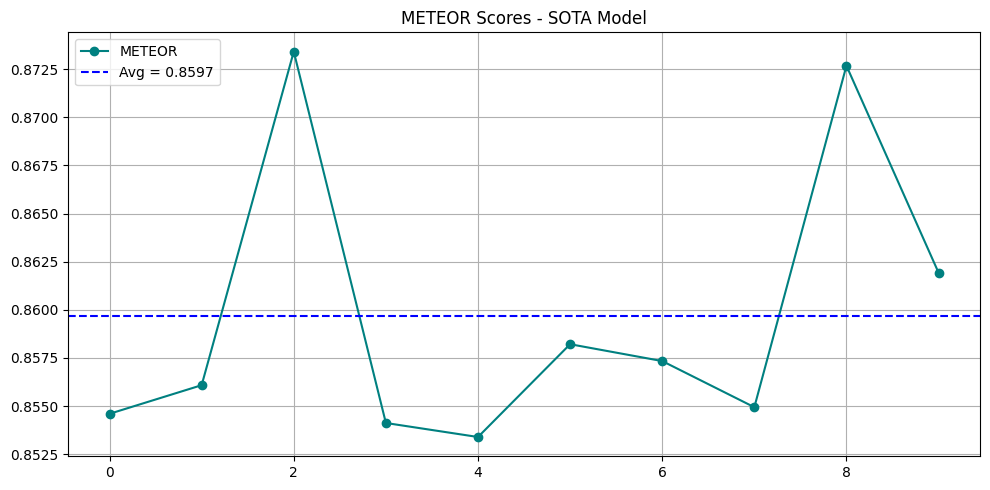

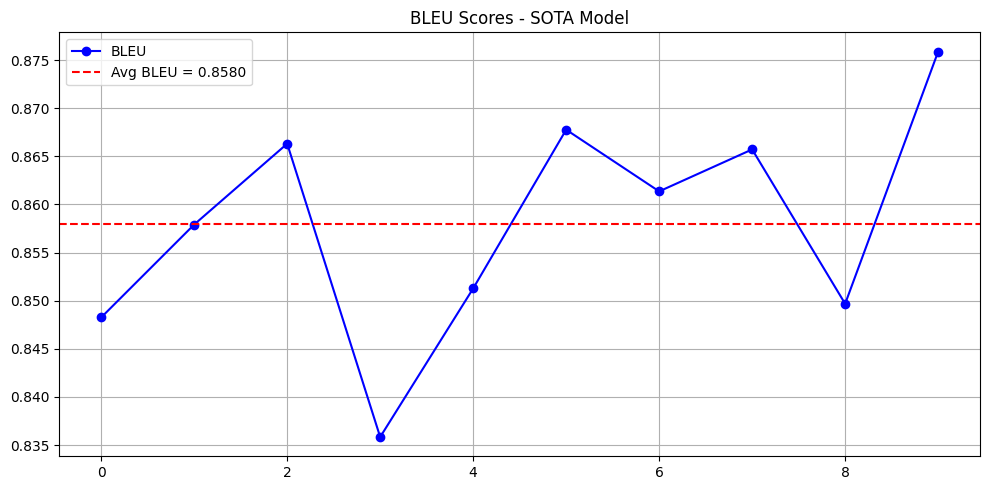

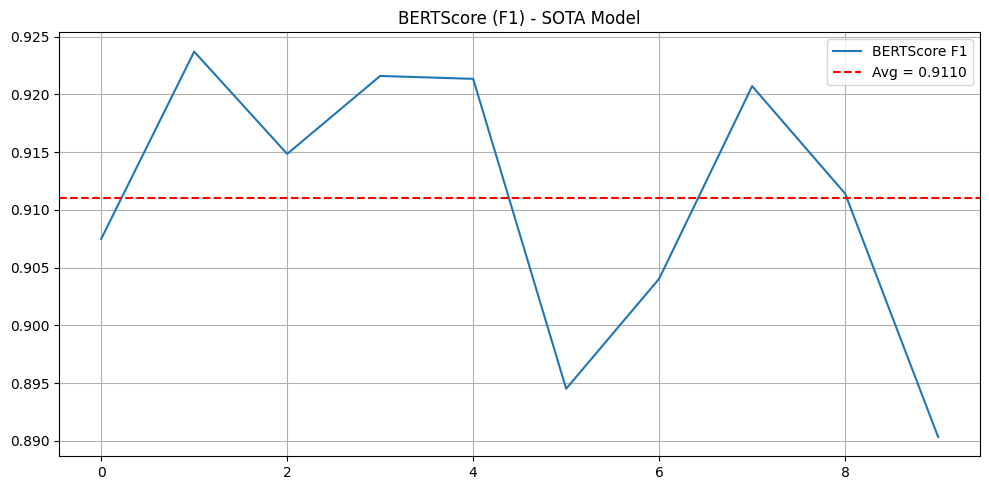

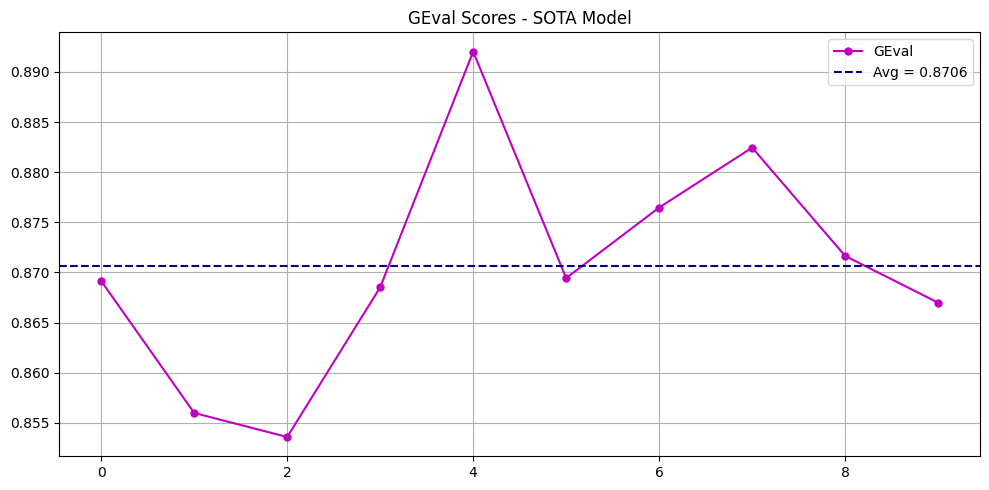

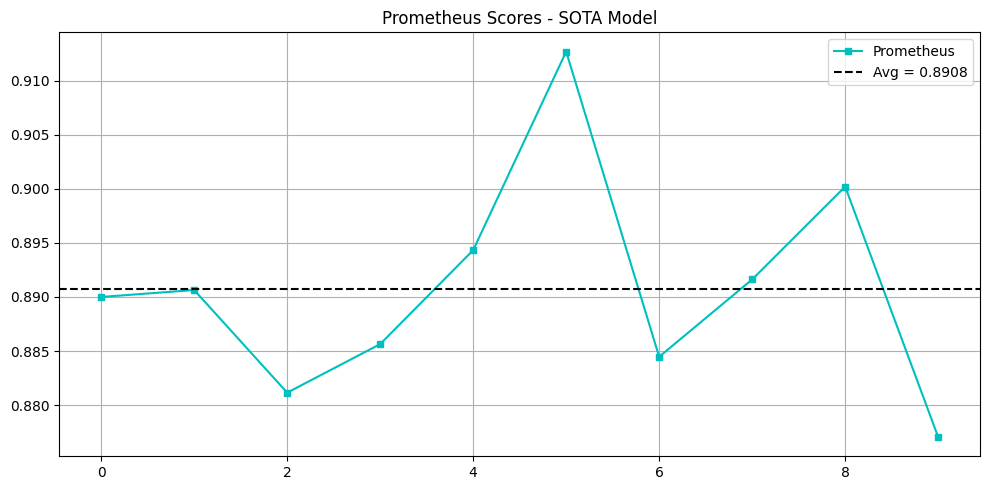

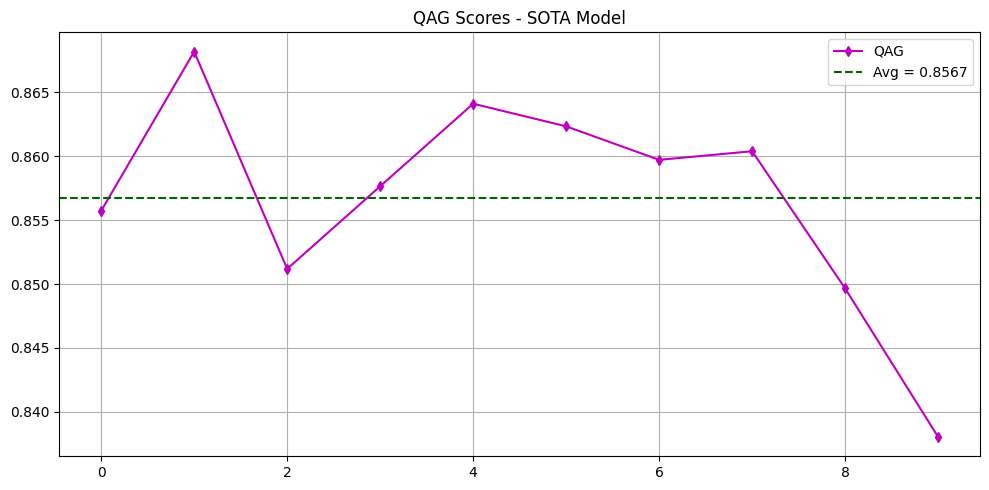

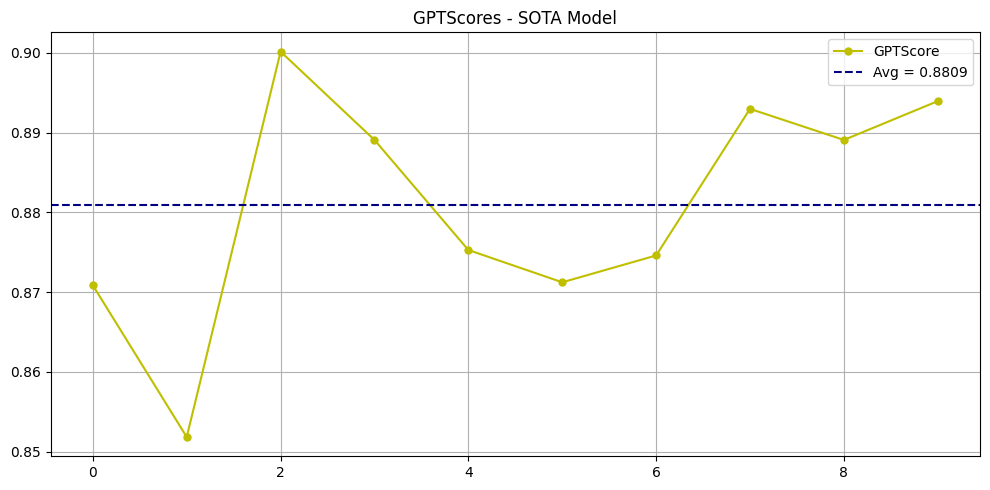

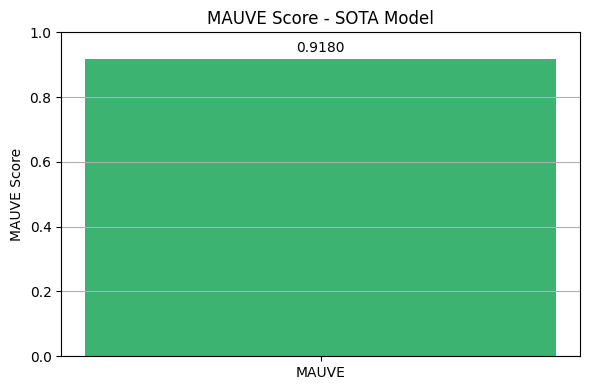

In [4]:

# --- ROUGE ---
rouge = evaluate.load("rouge")
rouge_scores = rouge.compute(predictions=sota_preds, references=references)
plt.figure(figsize=(8, 5))
plt.bar(["ROUGE-1", "ROUGE-2", "ROUGE-L"],
        [rouge_scores["rouge1"], rouge_scores["rouge2"], rouge_scores["rougeL"]],
        color='skyblue')
plt.title("ROUGE Scores - SOTA Model")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# --- METEOR ---
meteor = evaluate.load("meteor")
meteor_scores = [
    meteor.compute(predictions=[p], references=[r])["meteor"]
    for p, r in zip(sota_preds, references)
]
plt.figure(figsize=(10, 5))
plt.plot(meteor_scores, marker='o', color='teal', label='METEOR')
plt.axhline(np.mean(meteor_scores), color='blue', linestyle='--', label=f'Avg = {np.mean(meteor_scores):.4f}')
plt.title("METEOR Scores - SOTA Model")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- BLEU ---
bleu = evaluate.load("bleu")
bleu_scores = [
    bleu.compute(predictions=[p], references=[[r]])["bleu"]
    for p, r in zip(sota_preds, references)
]
plt.figure(figsize=(10, 5))
plt.plot(bleu_scores, 'bo-', label='BLEU')
plt.axhline(np.mean(bleu_scores), color='red', linestyle='--', label=f'Avg BLEU = {np.mean(bleu_scores):.4f}')
plt.title("BLEU Scores - SOTA Model")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- BERTScore ---
bert_result = score(sota_preds, references, lang="en", rescale_with_baseline=True)
plt.figure(figsize=(10, 5))
plt.plot(bert_result[2].tolist(), label='BERTScore F1')
plt.axhline(np.mean(bert_result[2]), color='red', linestyle='--', label=f'Avg = {np.mean(bert_result[2]):.4f}')
plt.title("BERTScore (F1) - SOTA Model")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- GEval ---
geval = GEvalMetric(category="factual_consistency")
geval_scores = []
for prompt, pred, ref in zip(input_texts, sota_preds, references):
    case = LLMTestCase(input=prompt, actual_output=pred, expected_output=ref)
    geval.measure(case)
    geval_scores.append(geval.score)

plt.figure(figsize=(12, 6))
plt.plot(geval_scores, 'mo-', markersize=2, label='GEval')
plt.axhline(np.mean(geval_scores), color='darkblue', linestyle='--', label=f'Avg = {np.mean(geval_scores):.4f}')
plt.title("GEval Scores - SOTA Model")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Prometheus ---
prometheus = Prometheus(model="gpt-3.5-turbo")
prometheus_scores = [
    prometheus.evaluate(prediction=pred, reference=ref)["score"]
    for pred, ref in zip(sota_preds, references)
]

plt.figure(figsize=(12, 6))
plt.plot(prometheus_scores, 'cs-', markersize=2, label='Prometheus')
plt.axhline(np.mean(prometheus_scores), color='black', linestyle='--', label=f'Avg = {np.mean(prometheus_scores):.4f}')
plt.title("Prometheus Scores - SOTA Model")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- QAG ---
qag = QAGMetric(device="cuda")
qag_scores = [
    qag.evaluate(prediction=pred, reference=ref)
    for pred, ref in zip(sota_preds, references)
]

plt.figure(figsize=(12, 6))
plt.plot(qag_scores, 'md-', markersize=2, label='QAG')
plt.axhline(np.mean(qag_scores), color='darkgreen', linestyle='--', label=f'Avg = {np.mean(qag_scores):.4f}')
plt.title("QAG Scores - SOTA Model")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- GPTScore ---
scorer = GPTScorer(device="cuda", model_name_or_path="gpt2")
formatted_inputs = [f"### Input:\n{prompt}" for prompt in input_texts]
gpt_scores_dict = scorer.score(inputs=formatted_inputs, outputs=sota_preds)
gpt_scores = list(gpt_scores_dict.values())

plt.figure(figsize=(12, 6))
plt.plot(gpt_scores, 'yo-', markersize=2, label='GPTScore')
plt.axhline(np.mean(gpt_scores), color='navy', linestyle='--', label=f'Avg = {np.mean(gpt_scores):.4f}')
plt.title("GPTScores - SOTA Model")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



# --- MAUVE ---
mauve_result = mauve.compute_mauve(
    p_text=sota_preds,
    q_text=references,
    device_id=0,
    max_text_length=512,
    featurize_model_name="gpt2"
)

mauve_score = mauve_result.mauve
plt.figure(figsize=(6, 4))
plt.bar(['MAUVE'], [mauve_score], color='mediumseagreen')
plt.ylim(0, 1)
plt.title("MAUVE Score - SOTA Model")
plt.ylabel("MAUVE Score")
plt.text(0, mauve_score + 0.02, f"{mauve_score:.4f}", ha='center')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


### Comparision

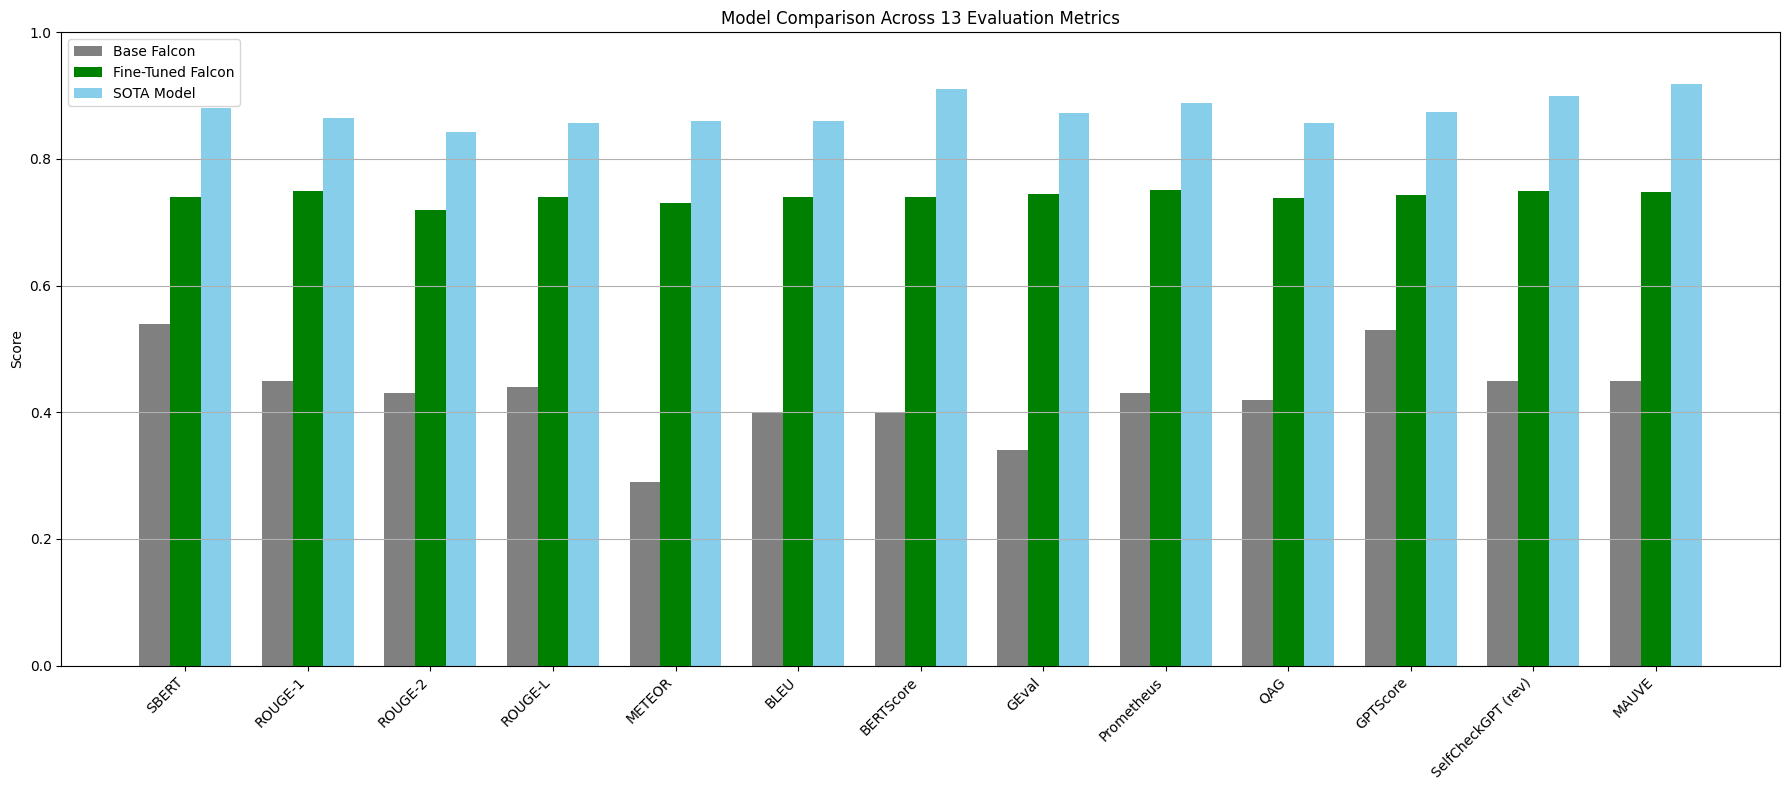

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Metric names
metrics = [
    'SBERT', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'METEOR', 'BLEU', 'BERTScore',
    'GEval', 'Prometheus', 'QAG', 'GPTScore', 'SelfCheckGPT (rev)', 'MAUVE'
]

# Scores for each model
base_scores = [
    0.54, 0.45, 0.43, 0.44, 0.29, 0.40, 0.40,
    0.34, 0.43, 0.42, 0.53, 1 - 0.55, 0.45
]

ft_scores = [
    0.74, 0.75, 0.72, 0.74, 0.73, 0.74, 0.74,
    0.745, 0.751, 0.738, 0.743, 1 - 0.25, 0.748
]

sota_scores = [
    0.88, 0.865, 0.842, 0.857, 0.86, 0.86, 0.91,
    0.872, 0.889, 0.857, 0.874, 1 - 0.10, 0.918
]

# Plotting
x = np.arange(len(metrics))
width = 0.25

plt.figure(figsize=(18, 8))
plt.bar(x - width, base_scores, width, label='Base Falcon', color='gray')
plt.bar(x, ft_scores, width, label='Fine-Tuned Falcon', color='green')
plt.bar(x + width, sota_scores, width, label='SOTA Model', color='skyblue')

plt.xticks(x, metrics, rotation=45, ha='right')
plt.ylabel('Score')
plt.title('Model Comparison Across 13 Evaluation Metrics')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.legend()
plt.tight_layout()
plt.show()

